### 라이브러리 임포트

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

2022-08-18 21:44:00.226719: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### GPU 체크

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

2022-08-18 21:44:15.963678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:44:20.496404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:44:20.499138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### ResNet 레이어 구성

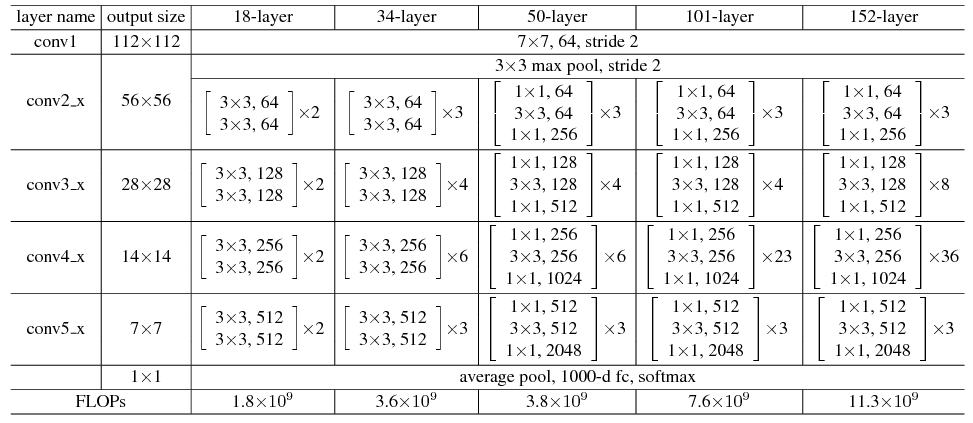

In [1]:
from IPython.display import Image
Image(filename='capture/resnet_list.png') 

### 기본 블록 구성

In [4]:
# 기본 블록 구성하기
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

### ResNet 기본 블록 구성

기본은 ResNet34 이고, is_50 이 True 인 경우에만 ResNet50

In [5]:
# ResNet 기본 블록 구성하기
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

### ResNet 모델 구성

In [6]:
# ResNet 모델 구성하기
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### PlainNet 기본 블록 구성하기

ResNet 에서 short-cut connection 을 없앤 것을 PlainNet 으로 하고, 비교하기 위해서 정의

In [7]:
# PlainNet 기본 블록 구성하기
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

### PlainNet 모델 구성

In [8]:
# PlainNet 모델 구성하기
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 테스트 할 데이터셋 로드

In [9]:
# cats_vs_dogs 데이터셋 로드하기
import urllib3
urllib3.disable_warnings()

# cats_vs_dogs 데이터셋이 tensorflow API 오류로 불러오지 못하는 경우가 있을 경우
# 로드하기 전에 이것을 추가해서 새 URL을 설정할 수 있습니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train_org, ds_test_org), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True, # 데이터가 튜플로 반환, False는 dictionarty형태로 반환
    with_info=True, # 데이터의 정보를 같이 반환한다.
)

2022-08-18 21:44:44.263960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 21:44:44.264375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:44:44.267315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:44:44.269523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

### 데이터 전처리 함수 정의

In [10]:
# 데이터 전처리하기(정규화 함수 만들기)
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 변수 선언

In [11]:
BATCH_SIZE = 32
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train_org, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test_org, batch_size=BATCH_SIZE)

### ResNet34 학습

In [12]:
# resnet_34 학습하기
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

 rmalization)                                                                                     
                                                                                                  
 add_3 (Add)                    (None, 28, 28, 128)  0           ['batch_normalization_9[0][0]',  
                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 activation_8 (Activation)      (None, 28, 28, 128)  0           ['add_3[0][0]']                  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 28, 28, 128)  512        ['conv2d_10[0][0]']              
 ormalizat

 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 14, 14, 256)  0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 14, 14, 256)  590080      ['activation_17[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 14, 14, 256)  0           ['batch_normalization_20[0][0]', 
          

                                                                                                  
 batch_normalization_30 (BatchN  (None, 7, 7, 512)   2048        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 7, 7, 512)    0           ['batch_normalization_30[0][0]'] 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 7, 7, 512)    2359808     ['activation_27[0][0]']          
                                                                                                  
 conv2d_29 (Conv2D)             (None, 7, 7, 512)    131584      ['activation_26[0][0]']          
                                                                                                  
 batch_nor

In [13]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/home/ubuntu/venv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2022-08-18 21:46:24.594187: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


 29/581 [>.............................] - ETA: 1:32 - loss: 2.8420 - accuracy: 0.5269

 39/581 [=>............................] - ETA: 1:30 - loss: 2.7491 - accuracy: 0.5288

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:18 - loss: 2.5040 - accuracy: 0.5652

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 43s - loss: 2.2380 - accuracy: 0.6009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 2.2276 - accuracy: 0.6023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 40s - loss: 2.2181 - accuracy: 0.6039

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 35s - loss: 2.1863 - accuracy: 0.6079

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 34s - loss: 2.1800 - accuracy: 0.6086

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.9838 - accuracy: 0.6243

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.9828 - accuracy: 0.6244

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 296s 199ms/step - loss: 1.9828 - accuracy: 0.6244 - val_loss: 4.9530 - val_accuracy: 0.5129
Epoch 2/10
 30/581 [>.............................] - ETA: 1:37 - loss: 1.4838 - accuracy: 0.6187

 42/581 [=>............................] - ETA: 1:35 - loss: 1.4621 - accuracy: 0.6391

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:22 - loss: 1.4025 - accuracy: 0.6654

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 46s - loss: 1.2893 - accuracy: 0.6726

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 44s - loss: 1.2821 - accuracy: 0.6753

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 42s - loss: 1.2770 - accuracy: 0.6757

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 37s - loss: 1.2618 - accuracy: 0.6780

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 1.2584 - accuracy: 0.6783

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.1669 - accuracy: 0.6930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1663 - accuracy: 0.6932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 1.1663 - accuracy: 0.6932 - val_loss: 1.0154 - val_accuracy: 0.6578
Epoch 3/10
 31/581 [>.............................] - ETA: 1:38 - loss: 0.9274 - accuracy: 0.7209

 40/581 [=>............................] - ETA: 1:36 - loss: 0.9192 - accuracy: 0.7291

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:24 - loss: 0.8954 - accuracy: 0.7439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 46s - loss: 0.8359 - accuracy: 0.7606

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 44s - loss: 0.8337 - accuracy: 0.7613

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 42s - loss: 0.8336 - accuracy: 0.7607

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 37s - loss: 0.8298 - accuracy: 0.7600

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 36s - loss: 0.8289 - accuracy: 0.7596

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.7702

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 204ms/step - loss: 0.7884 - accuracy: 0.7702 - val_loss: 0.9276 - val_accuracy: 0.6370
Epoch 4/10
  1/581 [..............................] - ETA: 1:44 - loss: 0.6389 - accuracy: 0.8438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:38 - loss: 0.6578 - accuracy: 0.8059

 44/581 [=>............................] - ETA: 1:36 - loss: 0.6597 - accuracy: 0.8033

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:23 - loss: 0.6593 - accuracy: 0.8002

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 46s - loss: 0.6502 - accuracy: 0.8034

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 44s - loss: 0.6507 - accuracy: 0.8023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 42s - loss: 0.6493 - accuracy: 0.8028

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 37s - loss: 0.6439 - accuracy: 0.8042

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 36s - loss: 0.6447 - accuracy: 0.8036

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.8072

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.6284 - accuracy: 0.8072 - val_loss: 1.0727 - val_accuracy: 0.5409
Epoch 5/10
  2/581 [..............................] - ETA: 1:43 - loss: 0.6521 - accuracy: 0.7812

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:37 - loss: 0.6548 - accuracy: 0.7850

 43/581 [=>............................] - ETA: 1:36 - loss: 0.6489 - accuracy: 0.7871

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:22 - loss: 0.6110 - accuracy: 0.8053

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 45s - loss: 0.5819 - accuracy: 0.8223

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 44s - loss: 0.5801 - accuracy: 0.8228

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 42s - loss: 0.5778 - accuracy: 0.8242

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 37s - loss: 0.5729 - accuracy: 0.8261

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 36s - loss: 0.5720 - accuracy: 0.8264

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.8343

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.5503 - accuracy: 0.8343 - val_loss: 2.4983 - val_accuracy: 0.4981
Epoch 6/10
  2/581 [..............................] - ETA: 1:43 - loss: 0.4537 - accuracy: 0.8750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:37 - loss: 0.5012 - accuracy: 0.8545

 43/581 [=>............................] - ETA: 1:36 - loss: 0.4981 - accuracy: 0.8532

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:23 - loss: 0.4945 - accuracy: 0.8574

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 46s - loss: 0.4756 - accuracy: 0.8650

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 44s - loss: 0.4760 - accuracy: 0.8651

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 41s - loss: 0.4762 - accuracy: 0.8646

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 37s - loss: 0.4761 - accuracy: 0.8645

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 35s - loss: 0.4761 - accuracy: 0.8645

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.8660

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.4767 - accuracy: 0.8660 - val_loss: 1.0097 - val_accuracy: 0.5335
Epoch 7/10
  3/581 [..............................] - ETA: 1:44 - loss: 0.4548 - accuracy: 0.8750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:37 - loss: 0.4884 - accuracy: 0.8641

 46/581 [=>............................] - ETA: 1:35 - loss: 0.4983 - accuracy: 0.8567

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:22 - loss: 0.4724 - accuracy: 0.8651

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 45s - loss: 0.4457 - accuracy: 0.8767

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 43s - loss: 0.4461 - accuracy: 0.8769

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 41s - loss: 0.4462 - accuracy: 0.8767

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 36s - loss: 0.4456 - accuracy: 0.8759

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 35s - loss: 0.4453 - accuracy: 0.8758

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8806

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.4346 - accuracy: 0.8806 - val_loss: 0.7567 - val_accuracy: 0.7181
Epoch 8/10
  3/581 [..............................] - ETA: 1:42 - loss: 0.3765 - accuracy: 0.9167

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:37 - loss: 0.3916 - accuracy: 0.8955

 46/581 [=>............................] - ETA: 1:36 - loss: 0.3965 - accuracy: 0.8913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:22 - loss: 0.4128 - accuracy: 0.8835

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 45s - loss: 0.4030 - accuracy: 0.8919

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 43s - loss: 0.4054 - accuracy: 0.8909

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 0.4058 - accuracy: 0.8916

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.4050 - accuracy: 0.8914

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 0.4042 - accuracy: 0.8914

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8920

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 204ms/step - loss: 0.4028 - accuracy: 0.8920 - val_loss: 0.5232 - val_accuracy: 0.8504
Epoch 9/10
  6/581 [..............................] - ETA: 1:43 - loss: 0.3491 - accuracy: 0.9219

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:37 - loss: 0.3736 - accuracy: 0.9095

 48/581 [=>............................] - ETA: 1:36 - loss: 0.3837 - accuracy: 0.9010

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:23 - loss: 0.3889 - accuracy: 0.9010

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 45s - loss: 0.3889 - accuracy: 0.9046

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 43s - loss: 0.3891 - accuracy: 0.9041

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 0.3917 - accuracy: 0.9023

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.3911 - accuracy: 0.9026

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 0.3923 - accuracy: 0.9016

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.9044

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 204ms/step - loss: 0.3817 - accuracy: 0.9044 - val_loss: 0.5813 - val_accuracy: 0.7756
Epoch 10/10
  5/581 [..............................] - ETA: 1:43 - loss: 0.3862 - accuracy: 0.8875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:37 - loss: 0.3909 - accuracy: 0.8857

 48/581 [=>............................] - ETA: 1:35 - loss: 0.3909 - accuracy: 0.8854

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:22 - loss: 0.3754 - accuracy: 0.8994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 45s - loss: 0.3754 - accuracy: 0.9028

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 43s - loss: 0.3744 - accuracy: 0.9038

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 40s - loss: 0.3734 - accuracy: 0.9040

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 35s - loss: 0.3709 - accuracy: 0.9048

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 34s - loss: 0.3711 - accuracy: 0.9046

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.9096

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 117s 202ms/step - loss: 0.3630 - accuracy: 0.9096 - val_loss: 0.6656 - val_accuracy: 0.7616


### ResNet50 학습

In [14]:
# resnet_50 학습하기
resnet_50 = build_resnet(input_shape=(224, 224, 3),  
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

                                                                                                  
 conv2d_46 (Conv2D)             (None, 28, 28, 256)  16640       ['activation_41[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 28, 28, 256)  1024       ['conv2d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 28, 28, 256)  0           ['batch_normalization_46[0][0]', 
                                                                  'activation_39[0][0]']          
                                                                                                  
 activation_42 (Activation)     (None, 28, 28, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 14, 14, 512)  0           ['batch_normalization_56[0][0]', 
                                                                  'activation_48[0][0]']          
                                                                                                  
 activation_51 (Activation)     (None, 14, 14, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv2d_57 (Conv2D)             (None, 14, 14, 128)  65664       ['activation_51[0][0]']          
                                                                                                  
 batch_normalization_57 (BatchN  (None, 14, 14, 128)  512        ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_67 (BatchN  (None, 7, 7, 256)   1024        ['conv2d_67[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 7, 7, 256)    0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 conv2d_68 (Conv2D)             (None, 7, 7, 256)    590080      ['activation_61[0][0]']          
                                                                                                  
 batch_normalization_68 (BatchN  (None, 7, 7, 256)   1024        ['conv2d_68[0][0]']              
 ormalization)                                                                                    
          

 activation_71 (Activation)     (None, 7, 7, 256)    0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 7, 7, 1024)   263168      ['activation_71[0][0]']          
                                                                                                  
 batch_normalization_78 (BatchN  (None, 7, 7, 1024)  4096        ['conv2d_78[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_28 (Add)                   (None, 7, 7, 1024)   0           ['batch_normalization_78[0][0]', 
                                                                  'activation_69[0][0]']          
                                                                                                  
 activatio

                                                                                                  
 add_31 (Add)                   (None, 4, 4, 2048)   0           ['batch_normalization_88[0][0]', 
                                                                  'activation_78[0][0]']          
                                                                                                  
 activation_81 (Activation)     (None, 4, 4, 2048)   0           ['add_31[0][0]']                 
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['activation_81[0][0]']          
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_1 (Dense)                (None, 1)            2049        ['global_average_pooling2d_1[0][0
          

In [15]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 1:07 - loss: 6.3322 - accuracy: 0.5280

 41/581 [=>............................] - ETA: 1:06 - loss: 6.3589 - accuracy: 0.5198

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 57s - loss: 6.0223 - accuracy: 0.5679

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 32s - loss: 5.4125 - accuracy: 0.6051

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 30s - loss: 5.3762 - accuracy: 0.6052

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 29s - loss: 5.3518 - accuracy: 0.6066

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 26s - loss: 5.2778 - accuracy: 0.6106

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 25s - loss: 5.2593 - accuracy: 0.6129

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 4.7295 - accuracy: 0.6341

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 97s 145ms/step - loss: 4.7295 - accuracy: 0.6341 - val_loss: 3.4279 - val_accuracy: 0.6545
Epoch 2/10
 29/581 [>.............................] - ETA: 1:08 - loss: 3.2538 - accuracy: 0.7220

 41/581 [=>............................] - ETA: 1:06 - loss: 3.2441 - accuracy: 0.7271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:01 - loss: 3.1450 - accuracy: 0.7061

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 32s - loss: 2.8423 - accuracy: 0.7108

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 31s - loss: 2.8266 - accuracy: 0.7109

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 30s - loss: 2.8136 - accuracy: 0.7116

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 26s - loss: 2.7799 - accuracy: 0.7121

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 25s - loss: 2.7730 - accuracy: 0.7118

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.5486 - accuracy: 0.7231

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 83s 144ms/step - loss: 2.5486 - accuracy: 0.7231 - val_loss: 2.0992 - val_accuracy: 0.6760
Epoch 3/10
  1/581 [..............................] - ETA: 1:10 - loss: 1.9751 - accuracy: 0.7500

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:07 - loss: 1.9504 - accuracy: 0.7417

 41/581 [=>............................] - ETA: 1:06 - loss: 1.9282 - accuracy: 0.7424

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 57s - loss: 1.8786 - accuracy: 0.7495

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 32s - loss: 1.7647 - accuracy: 0.7554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 30s - loss: 1.7595 - accuracy: 0.7541

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 29s - loss: 1.7528 - accuracy: 0.7551

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 25s - loss: 1.7402 - accuracy: 0.7554

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 25s - loss: 1.7381 - accuracy: 0.7547

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.6453 - accuracy: 0.7607

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 83s 142ms/step - loss: 1.6453 - accuracy: 0.7607 - val_loss: 2.1668 - val_accuracy: 0.5859
Epoch 4/10
 32/581 [>.............................] - ETA: 1:07 - loss: 1.3787 - accuracy: 0.7744

 44/581 [=>............................] - ETA: 1:06 - loss: 1.3688 - accuracy: 0.7798

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 57s - loss: 1.3468 - accuracy: 0.7871

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 32s - loss: 1.2703 - accuracy: 0.7973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 30s - loss: 1.2662 - accuracy: 0.7967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 28s - loss: 1.2640 - accuracy: 0.7959

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 25s - loss: 1.2555 - accuracy: 0.7966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 24s - loss: 1.2553 - accuracy: 0.7963

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1998 - accuracy: 0.8015

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 142ms/step - loss: 1.1998 - accuracy: 0.8015 - val_loss: 2.4390 - val_accuracy: 0.5289
Epoch 5/10
  1/581 [..............................] - ETA: 1:08 - loss: 1.0387 - accuracy: 0.8438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:06 - loss: 1.0859 - accuracy: 0.7992

 44/581 [=>............................] - ETA: 1:05 - loss: 1.0693 - accuracy: 0.8068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 56s - loss: 1.0554 - accuracy: 0.8122

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 31s - loss: 1.0046 - accuracy: 0.8232

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 30s - loss: 1.0024 - accuracy: 0.8234

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 28s - loss: 1.0009 - accuracy: 0.8231

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 25s - loss: 0.9955 - accuracy: 0.8242

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 24s - loss: 0.9948 - accuracy: 0.8240

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.8305

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 142ms/step - loss: 0.9600 - accuracy: 0.8305 - val_loss: 3.3663 - val_accuracy: 0.5690
Epoch 6/10
  2/581 [..............................] - ETA: 1:11 - loss: 1.0232 - accuracy: 0.7969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:07 - loss: 0.8799 - accuracy: 0.8554

 44/581 [=>............................] - ETA: 1:06 - loss: 0.9016 - accuracy: 0.8480

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 57s - loss: 0.8994 - accuracy: 0.8349

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 31s - loss: 0.8716 - accuracy: 0.8384

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 30s - loss: 0.8764 - accuracy: 0.8372

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 28s - loss: 0.8769 - accuracy: 0.8378

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 25s - loss: 0.8780 - accuracy: 0.8388

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 24s - loss: 0.8784 - accuracy: 0.8386

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8446 - accuracy: 0.8452

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 83s 142ms/step - loss: 0.8446 - accuracy: 0.8452 - val_loss: 2.0024 - val_accuracy: 0.4978
Epoch 7/10
  5/581 [..............................] - ETA: 1:10 - loss: 0.7034 - accuracy: 0.8687

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:07 - loss: 0.7310 - accuracy: 0.8741

 47/581 [=>............................] - ETA: 1:05 - loss: 0.7390 - accuracy: 0.8690

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 57s - loss: 0.7233 - accuracy: 0.8713

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 31s - loss: 0.6912 - accuracy: 0.8789

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 30s - loss: 0.6890 - accuracy: 0.8797

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 28s - loss: 0.6866 - accuracy: 0.8806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 25s - loss: 0.6839 - accuracy: 0.8808

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 24s - loss: 0.6840 - accuracy: 0.8808

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.8806

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 83s 142ms/step - loss: 0.6720 - accuracy: 0.8806 - val_loss: 0.7384 - val_accuracy: 0.8340
Epoch 8/10
  4/581 [..............................] - ETA: 1:10 - loss: 0.6335 - accuracy: 0.9062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:07 - loss: 0.6763 - accuracy: 0.8741

 48/581 [=>............................] - ETA: 1:05 - loss: 0.6724 - accuracy: 0.8750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 56s - loss: 0.6370 - accuracy: 0.8839

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 31s - loss: 0.6261 - accuracy: 0.8851

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 29s - loss: 0.6228 - accuracy: 0.8859

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 28s - loss: 0.6209 - accuracy: 0.8865

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 25s - loss: 0.6180 - accuracy: 0.8866

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 24s - loss: 0.6169 - accuracy: 0.8868

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.8844

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 0.6176 - accuracy: 0.8844 - val_loss: 11.5016 - val_accuracy: 0.7084
Epoch 9/10
  5/581 [..............................] - ETA: 1:10 - loss: 0.6444 - accuracy: 0.8875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:06 - loss: 0.6361 - accuracy: 0.8818

 49/581 [=>............................] - ETA: 1:04 - loss: 0.6188 - accuracy: 0.8903

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 56s - loss: 0.5864 - accuracy: 0.8968

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 30s - loss: 0.5701 - accuracy: 0.8976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 29s - loss: 0.5682 - accuracy: 0.8987

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 28s - loss: 0.5664 - accuracy: 0.8987

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 24s - loss: 0.5635 - accuracy: 0.8997

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 24s - loss: 0.5620 - accuracy: 0.9001

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.9010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 142ms/step - loss: 0.5503 - accuracy: 0.9010 - val_loss: 0.6085 - val_accuracy: 0.8687
Epoch 10/10
  8/581 [..............................] - ETA: 1:10 - loss: 0.5320 - accuracy: 0.8984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:06 - loss: 0.5413 - accuracy: 0.8964

 48/581 [=>............................] - ETA: 1:05 - loss: 0.5379 - accuracy: 0.8945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 56s - loss: 0.5183 - accuracy: 0.8984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 31s - loss: 0.5121 - accuracy: 0.9048

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 29s - loss: 0.5112 - accuracy: 0.9052

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 27s - loss: 0.5098 - accuracy: 0.9053

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 24s - loss: 0.5117 - accuracy: 0.9041

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 23s - loss: 0.5126 - accuracy: 0.9038

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.9052

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 142ms/step - loss: 0.5136 - accuracy: 0.9052 - val_loss: 0.6572 - val_accuracy: 0.8474


### PlainNet34 학습

In [16]:
# plain_34 학습하기
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        369

                                                                 
 activation_98 (Activation)  (None, 14, 14, 256)       0         
                                                                 
 conv2d_106 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_106 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activation_99 (Activation)  (None, 14, 14, 256)       0         
                                                                 
 conv2d_107 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_107 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activatio

In [17]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 1:33 - loss: 2.3421 - accuracy: 0.5357

 38/581 [>.............................] - ETA: 1:32 - loss: 2.3188 - accuracy: 0.5362

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:19 - loss: 2.2085 - accuracy: 0.5299

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 44s - loss: 1.9534 - accuracy: 0.5814

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 42s - loss: 1.9413 - accuracy: 0.5828

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 1.9251 - accuracy: 0.5865

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 1.8973 - accuracy: 0.5892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 1.8916 - accuracy: 0.5898

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.7289 - accuracy: 0.5878

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 123s 196ms/step - loss: 1.7289 - accuracy: 0.5878 - val_loss: 1.5372 - val_accuracy: 0.4865
Epoch 2/10
 29/581 [>.............................] - ETA: 1:35 - loss: 1.2773 - accuracy: 0.6627

 41/581 [=>............................] - ETA: 1:33 - loss: 1.2837 - accuracy: 0.6509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:20 - loss: 1.2563 - accuracy: 0.6428

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 44s - loss: 1.1887 - accuracy: 0.6382

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 42s - loss: 1.1864 - accuracy: 0.6380

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 40s - loss: 1.1821 - accuracy: 0.6387

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 1.1750 - accuracy: 0.6394

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 1.1735 - accuracy: 0.6392

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.1165 - accuracy: 0.6521

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1162 - accuracy: 0.6521

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 1.1162 - accuracy: 0.6521 - val_loss: 2.3042 - val_accuracy: 0.5800
Epoch 3/10
 31/581 [>.............................] - ETA: 1:34 - loss: 0.9700 - accuracy: 0.6835

 43/581 [=>............................] - ETA: 1:32 - loss: 0.9734 - accuracy: 0.6781

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:20 - loss: 0.9555 - accuracy: 0.6829

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 44s - loss: 0.9208 - accuracy: 0.6862

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 0.9187 - accuracy: 0.6869

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 40s - loss: 0.9167 - accuracy: 0.6871

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 35s - loss: 0.9145 - accuracy: 0.6862

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 34s - loss: 0.9142 - accuracy: 0.6851

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8900 - accuracy: 0.6923

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.8900 - accuracy: 0.6923 - val_loss: 1.5976 - val_accuracy: 0.5496
Epoch 4/10
 33/581 [>.............................] - ETA: 1:34 - loss: 0.7924 - accuracy: 0.7415

 43/581 [=>............................] - ETA: 1:32 - loss: 0.7974 - accuracy: 0.7340

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:20 - loss: 0.7976 - accuracy: 0.7290

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 44s - loss: 0.7950 - accuracy: 0.7243

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 0.7921 - accuracy: 0.7261

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 0.7912 - accuracy: 0.7262

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 0.7901 - accuracy: 0.7265

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.7886 - accuracy: 0.7273

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.7296

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.7711 - accuracy: 0.7296 - val_loss: 2.4716 - val_accuracy: 0.5134
Epoch 5/10
  3/581 [..............................] - ETA: 1:39 - loss: 0.7870 - accuracy: 0.6875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:34 - loss: 0.7496 - accuracy: 0.7358

 43/581 [=>............................] - ETA: 1:32 - loss: 0.7339 - accuracy: 0.7435

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:20 - loss: 0.7208 - accuracy: 0.7463

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 44s - loss: 0.7157 - accuracy: 0.7486

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 0.7138 - accuracy: 0.7495

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 40s - loss: 0.7128 - accuracy: 0.7502

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 0.7140 - accuracy: 0.7481

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.7135 - accuracy: 0.7483

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7470

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.7062 - accuracy: 0.7470 - val_loss: 0.9215 - val_accuracy: 0.7106
Epoch 6/10
  4/581 [..............................] - ETA: 1:38 - loss: 0.6573 - accuracy: 0.7500

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:33 - loss: 0.6883 - accuracy: 0.7604

 44/581 [=>............................] - ETA: 1:32 - loss: 0.6743 - accuracy: 0.7685

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:19 - loss: 0.6681 - accuracy: 0.7642

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 44s - loss: 0.6516 - accuracy: 0.7699

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 0.6542 - accuracy: 0.7678

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 39s - loss: 0.6555 - accuracy: 0.7677

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 35s - loss: 0.6554 - accuracy: 0.7689

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 34s - loss: 0.6549 - accuracy: 0.7690

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.7684

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.6534 - accuracy: 0.7684 - val_loss: 3.3828 - val_accuracy: 0.4933
Epoch 7/10
  5/581 [..............................] - ETA: 1:39 - loss: 0.5239 - accuracy: 0.8313

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:33 - loss: 0.6109 - accuracy: 0.7911

 45/581 [=>............................] - ETA: 1:32 - loss: 0.6166 - accuracy: 0.7833

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:19 - loss: 0.6358 - accuracy: 0.7745

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 0.6271 - accuracy: 0.7791

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 41s - loss: 0.6272 - accuracy: 0.7795

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 39s - loss: 0.6243 - accuracy: 0.7813

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 35s - loss: 0.6249 - accuracy: 0.7812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 34s - loss: 0.6238 - accuracy: 0.7821

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.7874

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.6101 - accuracy: 0.7874 - val_loss: 1.9619 - val_accuracy: 0.4974
Epoch 8/10
  4/581 [..............................] - ETA: 1:39 - loss: 0.6195 - accuracy: 0.7969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:33 - loss: 0.6136 - accuracy: 0.7769

 48/581 [=>............................] - ETA: 1:31 - loss: 0.6088 - accuracy: 0.7682

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 0.6026 - accuracy: 0.7818

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 43s - loss: 0.5796 - accuracy: 0.7956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 41s - loss: 0.5803 - accuracy: 0.7954

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 39s - loss: 0.5805 - accuracy: 0.7951

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.5772 - accuracy: 0.7972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 33s - loss: 0.5774 - accuracy: 0.7964

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.8039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.5695 - accuracy: 0.8039 - val_loss: 0.6169 - val_accuracy: 0.7700
Epoch 9/10
  7/581 [..............................] - ETA: 1:37 - loss: 0.5484 - accuracy: 0.7991

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:33 - loss: 0.5353 - accuracy: 0.8193

 47/581 [=>............................] - ETA: 1:31 - loss: 0.5342 - accuracy: 0.8218

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:18 - loss: 0.5552 - accuracy: 0.8081

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 43s - loss: 0.5559 - accuracy: 0.8115

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 41s - loss: 0.5558 - accuracy: 0.8115

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 39s - loss: 0.5536 - accuracy: 0.8132

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.5507 - accuracy: 0.8143

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 33s - loss: 0.5511 - accuracy: 0.8141

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.8166

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 0.5456 - accuracy: 0.8166 - val_loss: 0.7227 - val_accuracy: 0.6097
Epoch 10/10
  6/581 [..............................] - ETA: 1:38 - loss: 0.5317 - accuracy: 0.8281

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 1:32 - loss: 0.5011 - accuracy: 0.8325

 50/581 [=>............................] - ETA: 1:30 - loss: 0.5205 - accuracy: 0.8263

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:18 - loss: 0.5186 - accuracy: 0.8275

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 43s - loss: 0.5131 - accuracy: 0.8313

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 41s - loss: 0.5141 - accuracy: 0.8305

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 39s - loss: 0.5152 - accuracy: 0.8295

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.5126 - accuracy: 0.8323

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 0.5128 - accuracy: 0.8320

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.8356

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.5027 - accuracy: 0.8356 - val_loss: 0.8231 - val_accuracy: 0.5793


### PlainNet50 학습

In [18]:
# plain_50 학습하기
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        416

                                                                 
 activation_131 (Activation)  (None, 28, 28, 128)      0         
                                                                 
 conv2d_139 (Conv2D)         (None, 28, 28, 128)       147584    
                                                                 
 batch_normalization_139 (Ba  (None, 28, 28, 128)      512       
 tchNormalization)                                               
                                                                 
 activation_132 (Activation)  (None, 28, 28, 128)      0         
                                                                 
 conv2d_140 (Conv2D)         (None, 28, 28, 512)       66048     
                                                                 
 batch_normalization_140 (Ba  (None, 28, 28, 512)      2048      
 tchNormalization)                                               
                                                                 
 activatio

 tchNormalization)                                               
                                                                 
 activation_149 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_157 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_157 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activation_150 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_158 (Conv2D)         (None, 14, 14, 1024)      263168    
                                                                 
 batch_normalization_158 (Ba  (None, 14, 14, 1024)     4096      
 tchNormalization)                                               
          

In [19]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 2:29 - loss: 5.2630 - accuracy: 0.5382

 39/581 [=>............................] - ETA: 2:26 - loss: 5.2189 - accuracy: 0.5240

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:07 - loss: 4.8748 - accuracy: 0.5154

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 1:11 - loss: 4.0948 - accuracy: 0.5144

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:07 - loss: 4.0533 - accuracy: 0.5141

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:04 - loss: 4.0214 - accuracy: 0.5130

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 57s - loss: 3.9462 - accuracy: 0.5136

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 55s - loss: 3.9302 - accuracy: 0.5135

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 1s - loss: 3.4941 - accuracy: 0.5125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 3.4878 - accuracy: 0.5124

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 189s 306ms/step - loss: 3.4878 - accuracy: 0.5124 - val_loss: 2.9633 - val_accuracy: 0.5686
Epoch 2/10
 29/581 [>.............................] - ETA: 2:30 - loss: 2.4629 - accuracy: 0.4925

 40/581 [=>............................] - ETA: 2:27 - loss: 2.4556 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:07 - loss: 2.3962 - accuracy: 0.5132

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:10 - loss: 2.2575 - accuracy: 0.5140

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:07 - loss: 2.2520 - accuracy: 0.5131

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:04 - loss: 2.2451 - accuracy: 0.5139

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 56s - loss: 2.2296 - accuracy: 0.5152

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 55s - loss: 2.2262 - accuracy: 0.5153

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 2.1152 - accuracy: 0.5189

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1142 - accuracy: 0.5186

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 301ms/step - loss: 2.1142 - accuracy: 0.5186 - val_loss: 1.8633 - val_accuracy: 0.5050
Epoch 3/10
 30/581 [>.............................] - ETA: 2:29 - loss: 1.8030 - accuracy: 0.5240

 42/581 [=>............................] - ETA: 2:26 - loss: 1.7994 - accuracy: 0.5201

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:06 - loss: 1.7867 - accuracy: 0.5144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:10 - loss: 1.7202 - accuracy: 0.5270

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:06 - loss: 1.7162 - accuracy: 0.5270

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:04 - loss: 1.7135 - accuracy: 0.5270

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 56s - loss: 1.7067 - accuracy: 0.5280

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 55s - loss: 1.7057 - accuracy: 0.5277

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.6638 - accuracy: 0.5364

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 174s 300ms/step - loss: 1.6638 - accuracy: 0.5364 - val_loss: 1.5326 - val_accuracy: 0.5106
Epoch 4/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:28 - loss: 1.5197 - accuracy: 0.5332

 41/581 [=>............................] - ETA: 2:25 - loss: 1.5237 - accuracy: 0.5320

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:06 - loss: 1.5200 - accuracy: 0.5092

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:09 - loss: 1.4965 - accuracy: 0.5041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:06 - loss: 1.4946 - accuracy: 0.5041

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:03 - loss: 1.4922 - accuracy: 0.5044

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 56s - loss: 1.4869 - accuracy: 0.5054

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 54s - loss: 1.4861 - accuracy: 0.5053

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4530 - accuracy: 0.5040

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 174s 300ms/step - loss: 1.4530 - accuracy: 0.5040 - val_loss: 1.3620 - val_accuracy: 0.4866
Epoch 5/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:28 - loss: 1.3656 - accuracy: 0.4906

 43/581 [=>............................] - ETA: 2:25 - loss: 1.3660 - accuracy: 0.4935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:06 - loss: 1.3636 - accuracy: 0.5087

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:09 - loss: 1.3496 - accuracy: 0.5152

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:06 - loss: 1.3485 - accuracy: 0.5159

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:03 - loss: 1.3471 - accuracy: 0.5158

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 55s - loss: 1.3433 - accuracy: 0.5144

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 54s - loss: 1.3422 - accuracy: 0.5151

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.3194 - accuracy: 0.5137

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 174s 299ms/step - loss: 1.3194 - accuracy: 0.5137 - val_loss: 1.2520 - val_accuracy: 0.5153
Epoch 6/10
  2/581 [..............................] - ETA: 2:36 - loss: 1.2374 - accuracy: 0.5625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:28 - loss: 1.2450 - accuracy: 0.5312

 45/581 [=>............................] - ETA: 2:25 - loss: 1.2435 - accuracy: 0.5292

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:06 - loss: 1.2743 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:09 - loss: 1.2644 - accuracy: 0.5132

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:06 - loss: 1.2622 - accuracy: 0.5141

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:02 - loss: 1.2604 - accuracy: 0.5144

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 55s - loss: 1.2566 - accuracy: 0.5142

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 53s - loss: 1.2557 - accuracy: 0.5153

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.2417 - accuracy: 0.5226

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 174s 300ms/step - loss: 1.2417 - accuracy: 0.5226 - val_loss: 1.1835 - val_accuracy: 0.5157
Epoch 7/10
  2/581 [..............................] - ETA: 2:35 - loss: 1.2089 - accuracy: 0.3438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:28 - loss: 1.1903 - accuracy: 0.4883

 44/581 [=>............................] - ETA: 2:25 - loss: 1.1923 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 2:05 - loss: 1.1834 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:09 - loss: 1.1546 - accuracy: 0.5135

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:05 - loss: 1.1550 - accuracy: 0.5159

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 1:02 - loss: 1.1569 - accuracy: 0.5177

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 54s - loss: 1.1635 - accuracy: 0.5188

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 53s - loss: 1.1648 - accuracy: 0.5188

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1810 - accuracy: 0.5195

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 174s 299ms/step - loss: 1.1810 - accuracy: 0.5195 - val_loss: 1.3589 - val_accuracy: 0.5000
Epoch 8/10
  3/581 [..............................] - ETA: 2:35 - loss: 1.3179 - accuracy: 0.4479

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 2:27 - loss: 1.2556 - accuracy: 0.4835

 44/581 [=>............................] - ETA: 2:25 - loss: 1.2477 - accuracy: 0.4929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:05 - loss: 1.2057 - accuracy: 0.4951

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 1:08 - loss: 1.1434 - accuracy: 0.5145

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:06 - loss: 1.1434 - accuracy: 0.5131

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:02 - loss: 1.1456 - accuracy: 0.5128

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 55s - loss: 1.1527 - accuracy: 0.5111

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 53s - loss: 1.1540 - accuracy: 0.5113

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1533 - accuracy: 0.5094

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 301ms/step - loss: 1.1533 - accuracy: 0.5094 - val_loss: 1.0975 - val_accuracy: 0.5048
Epoch 9/10
  6/581 [..............................] - ETA: 2:34 - loss: 1.1164 - accuracy: 0.5104

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 2:27 - loss: 1.1032 - accuracy: 0.5125

 48/581 [=>............................] - ETA: 2:24 - loss: 1.0980 - accuracy: 0.5176

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 2:04 - loss: 1.0851 - accuracy: 0.4927

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 1:08 - loss: 1.0614 - accuracy: 0.5045

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:05 - loss: 1.0641 - accuracy: 0.5035

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:02 - loss: 1.0654 - accuracy: 0.5027

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 55s - loss: 1.0673 - accuracy: 0.5032

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 53s - loss: 1.0674 - accuracy: 0.5042

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0571 - accuracy: 0.5046

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 173s 299ms/step - loss: 1.0571 - accuracy: 0.5046 - val_loss: 1.0262 - val_accuracy: 0.4965
Epoch 10/10
  6/581 [..............................] - ETA: 2:34 - loss: 1.0172 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 2:26 - loss: 1.0141 - accuracy: 0.5397

 47/581 [=>............................] - ETA: 2:24 - loss: 1.0110 - accuracy: 0.5346

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 2:03 - loss: 0.9959 - accuracy: 0.5364

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 1:07 - loss: 0.9815 - accuracy: 0.5489

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:04 - loss: 0.9800 - accuracy: 0.5495

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 1:00 - loss: 0.9793 - accuracy: 0.5501

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 53s - loss: 0.9782 - accuracy: 0.5523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 51s - loss: 0.9791 - accuracy: 0.5521

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9947 - accuracy: 0.5480

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 171s 295ms/step - loss: 0.9947 - accuracy: 0.5480 - val_loss: 1.1322 - val_accuracy: 0.5396


### 시각화하여 결과 비교

In [20]:
%matplotlib inline

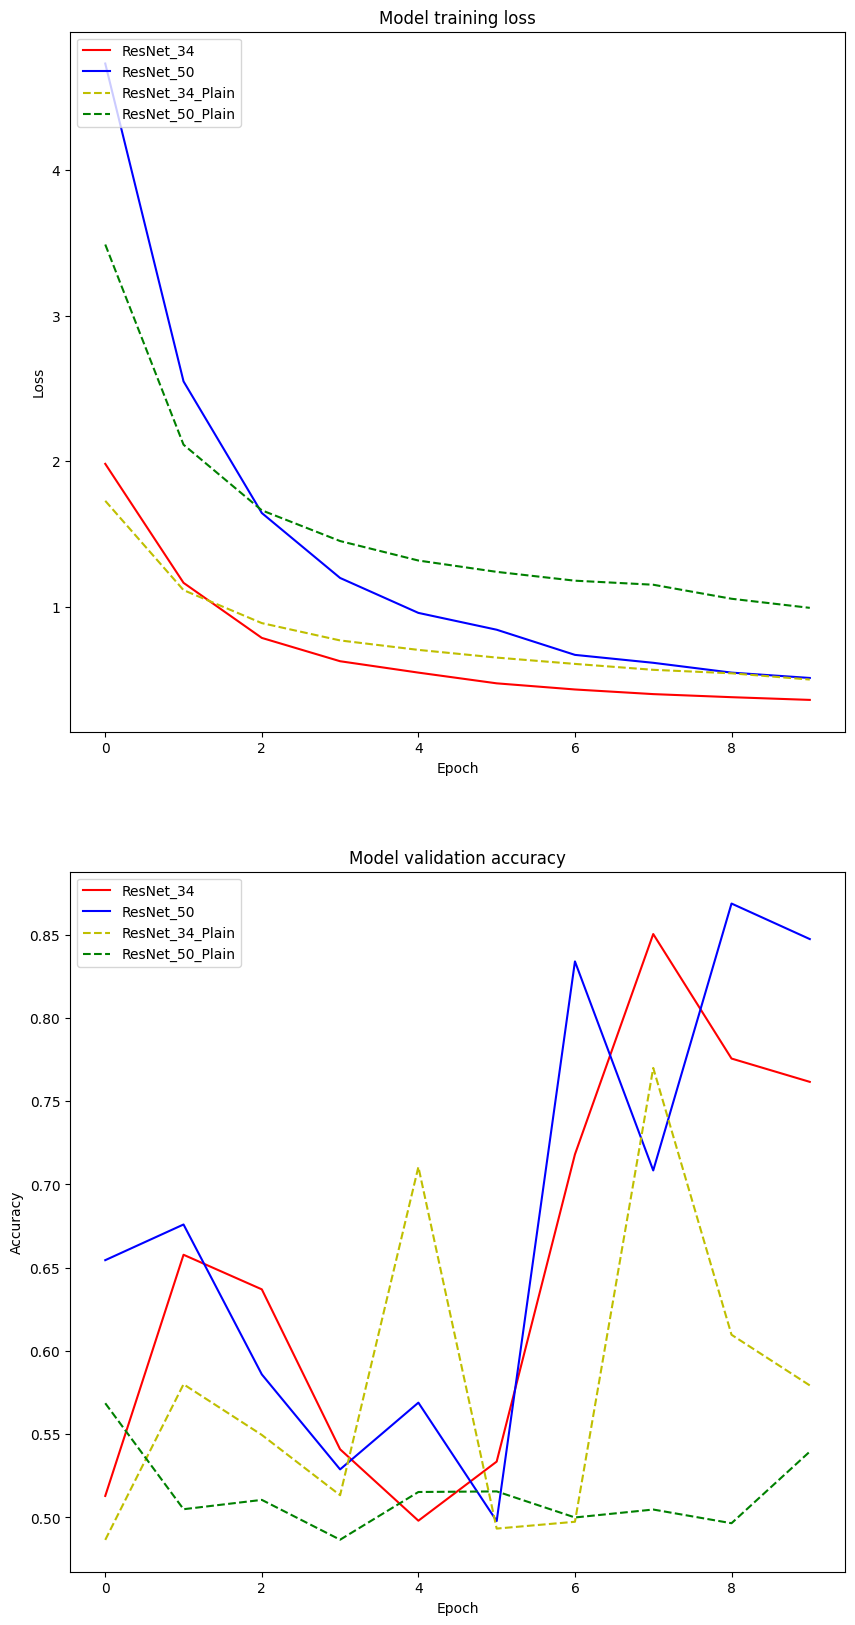

In [21]:
# 시각화하여 결과 비교하기
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y', linestyle='dashed')
plt.plot(history_plain_50.history['loss'], 'g', linestyle='dashed')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y', linestyle='dashed')
plt.plot(history_plain_50.history['val_accuracy'], 'g', linestyle='dashed')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')
plt.show()